# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import word_tokenize
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# 2. Exploratory Data Analysis

We needed to specify names for the columns in order to be able to read the dataset correctly otherwise parsing text containing delimiter symbol would raise error

Also there were two null objects in texts so we dropped them

In [2]:
df = pd.read_csv(
    'data/SmsCollection.csv',
    sep=';',
    names=['label', 'text'],
    skiprows=1,
    encoding='utf8').dropna()

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 0 to 5571
Data columns (total 2 columns):
label    5570 non-null object
text     5570 non-null object
dtypes: object(2)
memory usage: 130.5+ KB


In [4]:
df.describe()

,label,text
count,5570,5570
unique,2,5158
top,ham,"Sorry, I'll call later"
freq,4823,30


In [5]:
sns.set(
    style='whitegrid',
    palette='Set2',
    font_scale=1.4,
    rc={"figure.figsize": [10, 6]})

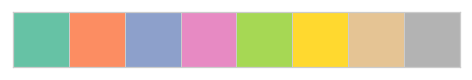

In [6]:
sns.palplot(sns.color_palette('Set2'))

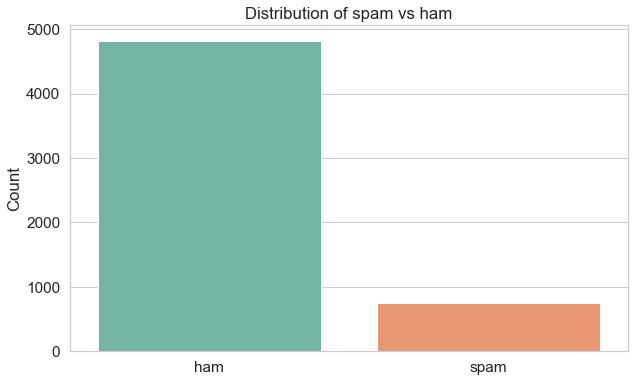

In [7]:
sns.countplot(df['label'])
plt.title('Distribution of spam vs ham')
plt.xlabel('')
plt.ylabel('Count')
plt.show()

## 2.1 Text Preprocessing

We clean the original textual data by removing non-alphanumeric characters

In [8]:
# remove all non-alphanumeric characters
df['text_processed'] = df['text'].apply(
    lambda s: re.sub(r'[^A-Za-z0-9 ]', ' ', s))

# remove stop words
# df['text_processed'] = df['text'].apply(lambda s: ' '.join(word for word in s.split() if word not in stop_words))


In [9]:
print('Before:\n' + df['text'][42] + '\n\nAfter:\n' + df['text_processed'][42])


Before:
07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow

After:
07732584351   Rodger Burns   MSG   We tried to call you re your reply to our sms for a free nokia mobile   free camcorder  Please call now 08000930705 for delivery tomorrow


## 2.2 Feature Engineering

In [10]:
print('Words:\n', word_tokenize(df['text_processed'][42]))
print('Count:\n', len(word_tokenize(df['text_processed'][42])))

Words:
 ['07732584351', 'Rodger', 'Burns', 'MSG', 'We', 'tried', 'to', 'call', 'you', 're', 'your', 'reply', 'to', 'our', 'sms', 'for', 'a', 'free', 'nokia', 'mobile', 'free', 'camcorder', 'Please', 'call', 'now', '08000930705', 'for', 'delivery', 'tomorrow']
Count:
 29


In [11]:
# number of words in text
df['words_count'] = df.apply(lambda row: len(word_tokenize(row['text_processed'])), axis=1)

df.head()


,label,text,text_processed,words_count
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only ...,20
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,33
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives aro...,14


We can see the most common text size in a message

In [12]:
print('ham:\n',
      Counter(df.loc[df['label'] == 'ham']['words_count']).most_common(25))
print('spam:\n',
      Counter(df.loc[df['label'] == 'spam']['words_count']).most_common(25))

ham:
 [(6, 414), (7, 378), (8, 354), (5, 350), (9, 320), (10, 259), (11, 221), (12, 219), (4, 174), (15, 158), (14, 143), (13, 134), (17, 133), (18, 118), (16, 104), (20, 100), (19, 86), (26, 79), (21, 78), (23, 77), (22, 73), (25, 70), (27, 67), (3, 66), (31, 57)]
spam:
 [(28, 83), (27, 75), (29, 73), (26, 61), (25, 59), (24, 52), (30, 49), (31, 40), (23, 33), (32, 26), (33, 25), (19, 18), (21, 16), (20, 15), (22, 14), (13, 14), (16, 10), (34, 10), (14, 9), (17, 9), (36, 8), (8, 8), (15, 7), (12, 5), (6, 4)]


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


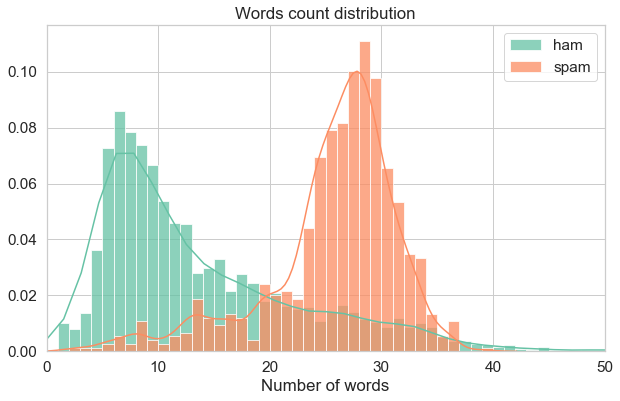

In [13]:
sns.distplot(
    df.loc[df['label'] == 'ham']['words_count'],
    bins=np.arange(0, 70),
    hist_kws={'alpha': .75},
    label='ham')

sns.distplot(
    df.loc[df['label'] == 'spam']['words_count'],
    bins=np.arange(0, 70),
    hist_kws={'alpha': .75},
    label='spam')

plt.xlim(0, 50)
plt.xlabel('Number of words')
plt.title('Words count distribution')
plt.legend()
plt.show()


Now we count number of characters in a text, i.e. message length (excluding spaces)


In [14]:
df['char_count'] = df['text_processed'].apply(
        lambda s: len(re.sub(r'[ ]', '', s)))

df.head()


,label,text,text_processed,words_count,char_count
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only ...,20,83
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,6,18
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,33,122
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,11,33
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives aro...,14,47


We can see the most common text length (number of characters) in a message for both labels

In [15]:
print('ham:\n',
      Counter(df.loc[df['label'] == 'ham']['char_count']).most_common(25))
print('spam:\n',
      Counter(df.loc[df['label'] == 'spam']['char_count']).most_common(25))

ham:
 [(20, 143), (17, 130), (19, 124), (24, 116), (26, 112), (23, 112), (25, 107), (28, 102), (21, 98), (22, 98), (30, 95), (32, 95), (18, 94), (29, 89), (27, 87), (40, 82), (31, 79), (38, 76), (36, 75), (35, 75), (37, 73), (33, 68), (34, 65), (39, 63), (43, 61)]
spam:
 [(124, 49), (125, 38), (127, 33), (120, 32), (122, 28), (121, 28), (116, 26), (118, 24), (126, 23), (119, 23), (130, 21), (117, 19), (108, 19), (128, 18), (107, 15), (106, 15), (123, 13), (110, 13), (109, 13), (114, 13), (113, 13), (115, 11), (111, 10), (98, 10), (105, 10)]


In principle the KDEs have to be similar to the previous ones

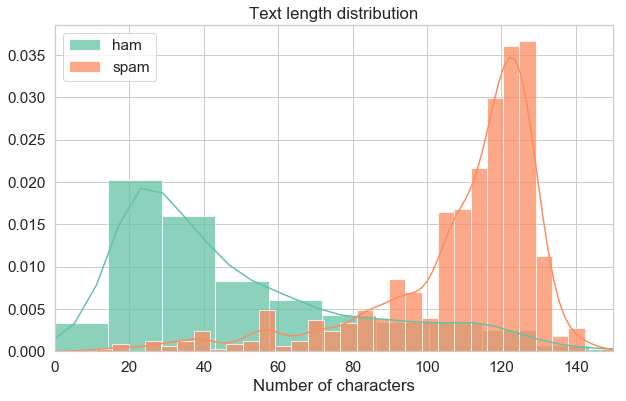

In [16]:
sns.distplot(
    df.loc[df['label'] == 'ham']['char_count'],
    hist_kws={'alpha': .75},
    label='ham')

sns.distplot(
    df.loc[df['label'] == 'spam']['char_count'],
    hist_kws={'alpha': .75},
    label='spam')

plt.xlim(0, 150)
plt.xlabel('Number of characters')
plt.title('Text length distribution')
plt.legend()
plt.show()


We can see some outliers after 140 characters and about 180 words

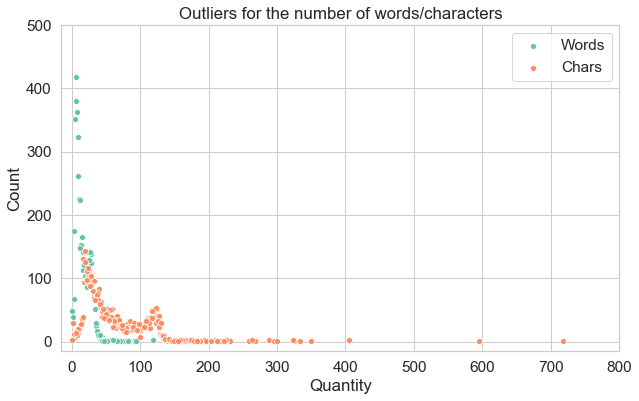

In [17]:
sns.scatterplot(
    x=list(Counter(df['words_count']).keys()),
    y=list(Counter(df['words_count']).values()),
    label='Words')

sns.scatterplot(
    x=list(Counter(df['char_count']).keys()),
    y=list(Counter(df['char_count']).values()),
    label='Chars')

plt.xlim(-15, 800)
plt.ylim(-15, 500)
plt.title('Outliers for the number of words/characters')
plt.ylabel('Count')
plt.xlabel('Quantity')
plt.legend()
plt.show()


We now can calculate the average word length per text message as a feature and see the distribution of it

In [18]:
# average word length in a text
df['avg_word_length'] = df.char_count / df.words_count

df.head()

,label,text,text_processed,words_count,char_count,avg_word_length
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only ...,20,83,4.150000
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,6,18,3.000000
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,33,122,3.696970
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,11,33,3.000000
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives aro...,14,47,3.357143


We know from the results here that there are a few interesting points in the dataset, let's see what they actually mean and interpret the results

In [19]:
df.loc[df['char_count'] < 2]

,label,text,text_processed,words_count,char_count,avg_word_length
3376,ham,:),,0,0,NaN
4824,ham,:-) :-),,0,0,NaN


We remove those single entries with anomalies to get representative distributions

In [24]:
df.drop(df.loc[df['char_count'] < 2].index, inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5568 entries, 0 to 5571
Data columns (total 6 columns):
label              5568 non-null object
text               5568 non-null object
text_processed     5568 non-null object
words_count        5568 non-null int64
char_count         5568 non-null int64
avg_word_length    5568 non-null float64
dtypes: float64(1), int64(2), object(3)
memory usage: 304.5+ KB


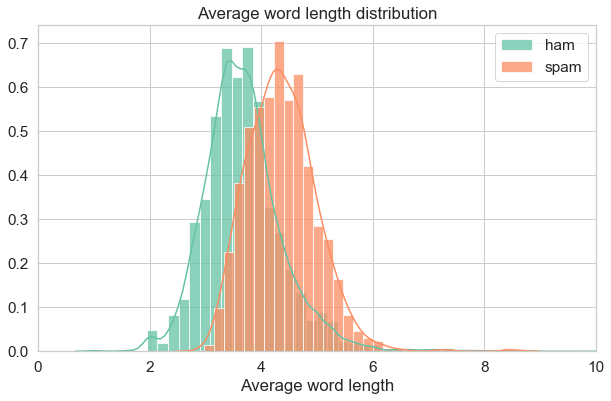

In [25]:
sns.distplot(
    df.loc[df['label'] == 'ham']['avg_word_length'],
    hist_kws={'alpha': .75},
    label='ham')

sns.distplot(
    df.loc[df['label'] == 'spam']['avg_word_length'],
    hist_kws={'alpha': .75},
    label='spam')

plt.xlim(0, 10)
plt.xlabel('Average word length')
plt.title('Average word length distribution')
plt.legend()
plt.show()


### 2.2.1 Sentiment Analysis

For the sentiment analysis we use the original data without cleaning as the VADER sentiment analysis tool already takes care of the preprocessing and it is especially tailored to use for internet text lexicon as it is seen to be used in the text messages

In [26]:
%%time
df = pd.concat([
    df, df['text'].apply(
        lambda s: SentimentIntensityAnalyzer().polarity_scores(s)).apply(
            pd.Series)
],
               axis=1)

CPU times: user 52.8 s, sys: 1.08 s, total: 53.9 s
Wall time: 54 s


After we calculate the sentiment intensity with VADER, we then mark the messages as positive/negative/neutral based on the compound component

In [27]:
df.loc[(df['compound'] > -.05) &
       (df['compound'] < .05), 'sentiment'] = 'neutral'
df.loc[df['compound'] <= -.05, 'sentiment'] = 'negative'
df.loc[df['compound'] >= .05, 'sentiment'] = 'positive'

df.head()


,label,text,text_processed,words_count,char_count,avg_word_length,neg,neu,pos,compound,sentiment
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only ...,20,83,4.150000,0.000,0.806,0.194,0.6249,positive
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,6,18,3.000000,0.000,0.423,0.577,0.4767,positive
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,33,122,3.696970,0.000,0.772,0.228,0.7964,positive
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,11,33,3.000000,0.000,1.000,0.000,0.0000,neutral
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives aro...,14,47,3.357143,0.113,0.887,0.000,-0.1027,negative


Now we can plot the results of the sentiment analysis and see the distribution for each label

In [28]:
print('overall:', Counter(df['sentiment']))
print('ham:', Counter(df.loc[df['label'] == 'ham']['sentiment']))
print('spam:', Counter(df.loc[df['label'] == 'spam']['sentiment']))


overall: Counter({'positive': 2625, 'neutral': 1952, 'negative': 991})
ham: Counter({'positive': 2080, 'neutral': 1855, 'negative': 886})
spam: Counter({'positive': 545, 'negative': 105, 'neutral': 97})


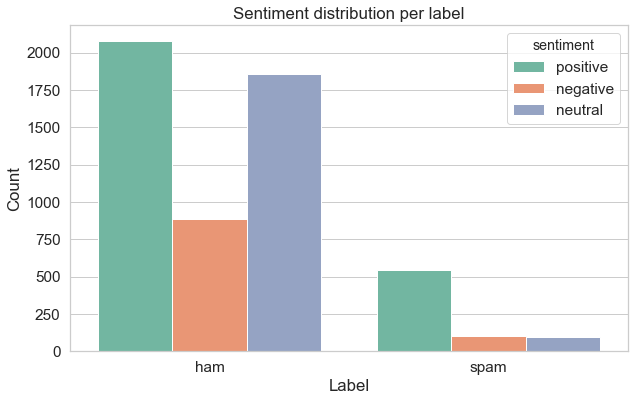

In [29]:
sns.countplot(
    x='label',
    hue='sentiment',
    data=df,
    hue_order=['positive', 'negative', 'neutral'])

plt.title('Sentiment distribution per label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


Let's now see the most common words for both labels. For this we exclude stop words and plot a word cloud.

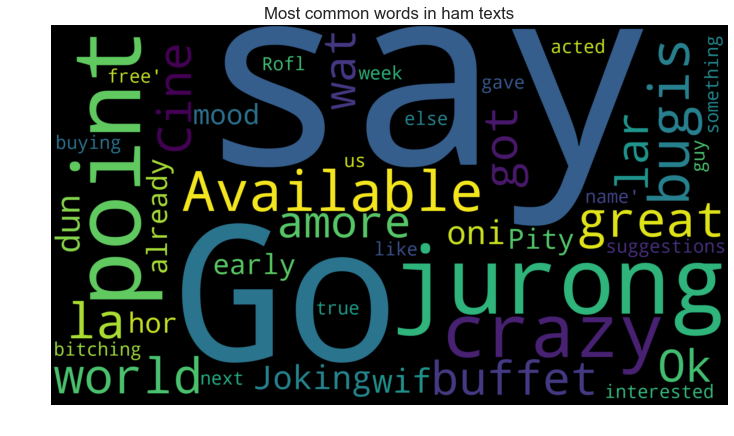

In [30]:
df_plot = df.loc[df['label'] == 'ham']['text_processed']

word_cloud = WordCloud(
    max_words=50, stopwords=stop_words, margin=10, width=1920,
    height=1080).generate(str(df_plot.values))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most common words in ham texts')
plt.show()


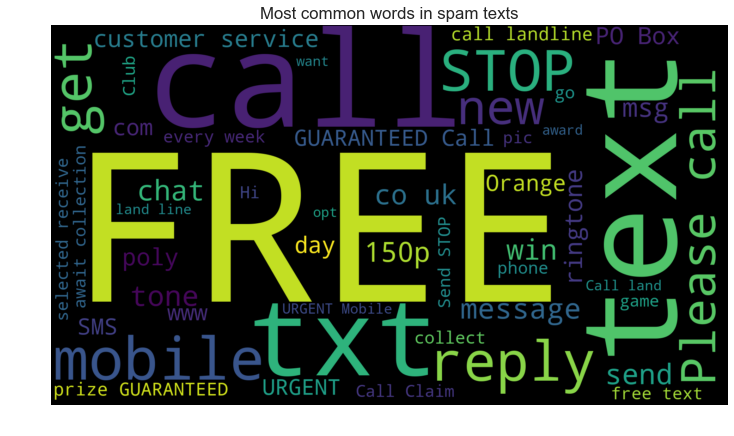

In [32]:
df_plot = df.loc[df['label'] == 'spam']['text_processed']

word_cloud = WordCloud(
    max_words=50, stopwords=stop_words, margin=10, width=1920,
    height=1080).generate(str(df_plot.values))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Most common words in spam texts')
plt.show()


Finally we will add a new feature - first we create a list of most common words in spam messages and then for each text we count a number of words which fall in this list

In [48]:
spam_list = [
    s for s, _ in Counter([
        word.lower()
        for word in word_tokenize(str(df_plot.values))
        if word not in stop_words and len(word) > 1 and not word.isdigit()
    ]).most_common(50)
]


In [55]:
print(spam_list)

['call', 'free', 'txt', 'ur', 'mobile', 'text', 'claim', 'stop', 'reply', 'www', 'prize', 'to', 'get', 'cash', 'send', 'nokia', 'your', 'new', 'uk', '150p', 'now', 'week', "'you", 'tone', 'contact', 'win', 'co', "'urgent", 'service', 'msg', 'you', 'guaranteed', 'no', 'per', 'customer', 'phone', 'please', 'chat', 'com', 'min', 'cs', 'draw', 'awarded', "'free", 'mins', 'line', 'latest', 'receive', 'box', 'every']


In [59]:
df['spam_words'] = df['text_processed'].apply(
    lambda s: len([word for word in word_tokenize(s) if word.lower() in spam_list]))

df.head()

,label,text,text_processed,words_count,char_count,avg_word_length,neg,neu,pos,compound,sentiment,spam_words
0,ham,"Go until jurong point, crazy.. Available only ...",Go until jurong point crazy Available only ...,20,83,4.150000,0.000,0.806,0.194,0.6249,positive,0
1,ham,Ok lar... Joking wif u oni...,Ok lar Joking wif u oni,6,18,3.000000,0.000,0.423,0.577,0.4767,positive,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry in 2 a wkly comp to win FA Cup fina...,33,122,3.696970,0.000,0.772,0.228,0.7964,positive,8
3,ham,U dun say so early hor... U c already then say...,U dun say so early hor U c already then say,11,33,3.000000,0.000,1.000,0.000,0.0000,neutral,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah I don t think he goes to usf he lives aro...,14,47,3.357143,0.113,0.887,0.000,-0.1027,negative,1
